In [223]:
import requests
from bs4 import BeautifulSoup
import sqlite3
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from scipy.stats import linregress
from collections import Counter

Defining a function to extract all links attached to a given website

In [112]:
def link (url):
    urls = []
    page = requests.get(url)
    soup = BeautifulSoup(page.content, "html.parser")
    links = soup.find_all('a')
    for i in links:
        urls.append(i['href'])
    return urls


In [113]:
all_links_facultypage = link("https://www.bio.iitb.ac.in/people/faculty/")

In [114]:
all_links_facultypage

['#main',
 'https://www.facebook.com/iitbbsbe/',
 'https://twitter.com/bsbeiitb',
 'https://www.bio.iitb.ac.in/',
 'https://www.bio.iitb.ac.in',
 'https://www.bio.iitb.ac.in/',
 'https://www.bio.iitb.ac.in/people/',
 'https://www.bio.iitb.ac.in/people/faculty/',
 '#',
 'https://www.bio.iitb.ac.in/people/phd-students/',
 'https://www.bio.iitb.ac.in/people/msc1/',
 'https://www.bio.iitb.ac.in/people/msc2/',
 'https://www.bio.iitb.ac.in/people/mtech1/',
 'https://www.bio.iitb.ac.in/people/mtech2/',
 'https://www.bio.iitb.ac.in/people/staff/',
 '#',
 'https://www.bio.iitb.ac.in/people/postdocs/',
 'https://www.bio.iitb.ac.in/people/former-pdf/',
 'https://www.bio.iitb.ac.in/people/project-staff/',
 '#',
 'https://www.bio.iitb.ac.in/people/phd-alumni/',
 'https://www.bio.iitb.ac.in/web/alumni/msc/msc-2021.html',
 'https://www.bio.iitb.ac.in/web/alumni/mtech/mtech-2019.html',
 'https://www.bio.iitb.ac.in/people/ms-mphil-alumni/',
 'https://www.bio.iitb.ac.in/research/',
 'https://www.bio.iit

Filtering the links to obtain only those associated with a faculty profile

In [115]:
target_portion = "www.bio.iitb.ac.in/people/faculty/"
filtered_urls = [url for url in all_links_facultypage if target_portion in url]
all_faculty_set = set(filtered_urls)
all_faculty = list(all_faculty_set)
all_faculty

['https://www.bio.iitb.ac.in/people/faculty/',
 'https://www.bio.iitb.ac.in/people/faculty/balaji-pv/',
 'https://www.bio.iitb.ac.in/people/faculty/purwar-r/',
 'https://www.bio.iitb.ac.in/people/faculty/punekar-ns/',
 'https://www.bio.iitb.ac.in/people/faculty/mallik-r/',
 'https://www.bio.iitb.ac.in/people/faculty/banerjee-r/',
 'https://www.bio.iitb.ac.in/people/faculty/tayalia-p/',
 'https://www.bio.iitb.ac.in/people/faculty/subrahmanyam-g/',
 'https://www.bio.iitb.ac.in/people/faculty/bhaumik-p/',
 'https://www.bio.iitb.ac.in/people/faculty/rao-kk/',
 'https://www.bio.iitb.ac.in/people/faculty/sen-s/',
 'https://www.bio.iitb.ac.in/people/faculty/bhat-pj/',
 'https://www.bio.iitb.ac.in/people/faculty/phale-ps/',
 'https://www.bio.iitb.ac.in/people/faculty/kondabagil-k/',
 'https://www.bio.iitb.ac.in/people/faculty/kunwar-ambarish/',
 'https://www.bio.iitb.ac.in/people/faculty/maji-sk/',
 'https://www.bio.iitb.ac.in/people/faculty/patankar-s/',
 'https://www.bio.iitb.ac.in/people/fa

Class names associated with different features of interest in the profile of each faculty

In [116]:
class_education_bio = "elementor-element-040f0d9"
class_research_interest_bio = "elementor-element-f2b316c"
class_professional_experience_bio = 'elementor-element-afe491e'
class_awards_bio = "elementor-element-f68a4fe"
class_publications_bio = 'elementor-element-3a3519f'
class_name_bio ='elementor-heading-title'

Defining a function to parse a website and identify information associated with education, research, etc

In [117]:
def parse(url,class_education,class_research_interest,class_professional_experience,class_awards,class_publications,class_name):
    try:
        # Add a timeout parameter (in seconds) to the request
        page = requests.get(url, timeout=60)  # Timeout set to 60 seconds, adjust as needed
        page.raise_for_status()  # Raise HTTPError for bad requests

        soup = BeautifulSoup(page.content, "html.parser")

        # Find the name of the faculty
        name_tag = soup.find('h2', class_=class_name)
        faculty_name = [name_tag.get_text()] if name_tag else []

        edu = soup.find('div', class_=class_education)
        edu_list = [li.text for li in edu.find_all("li")] if edu else []

        award = soup.find('div', class_=class_awards)
        award_list = [li.text for li in award.find_all("li")] if award else []

        prof_exp = soup.find('div', class_=class_professional_experience)
        prof_exp_list = [li.text for li in prof_exp.find_all("li")] if prof_exp else []

        pubs = soup.find('div', class_=class_publications)
        pubs_list = [li.text for li in pubs.find_all("li")] if pubs else []

        res_int = soup.find('div', class_=class_research_interest)
        res_int_list = [li.text for li in res_int.find_all("li")] if res_int else []

        faculty_info = [faculty_name, edu_list, award_list, prof_exp_list, pubs_list, res_int_list]

        return faculty_info

    except requests.exceptions.Timeout:
        print(f"Timeout occurred while accessing {url}")
        return [[]]
    except requests.exceptions.HTTPError as errh:
        print(f"HTTP Error occurred: {errh}")
        return [[]]
    except requests.exceptions.RequestException as err:
        print(f"Request Exception occurred: {err}")
        return [[]]

Storing and retrieving data from an SQL database

In [118]:
# # SQLite database setup
# conn = sqlite3.connect('faculty_detail_biology.db')
# cursor = conn.cursor()

# # Create a table to store faculty details if it doesn't exist
# cursor.execute('''CREATE TABLE IF NOT EXISTS faculty (
#                   id INTEGER PRIMARY KEY AUTOINCREMENT,
#                   name TEXT,
#                   education TEXT,
#                   awards TEXT,
#                   professional_experience TEXT,
#                   publications TEXT,
#                   research_interest TEXT
#                   )''')
# conn.commit()

# # Iterate through each URL, parse data, and store in the database
# for url in all_faculty:
#     faculty_info = parse(url, class_education_bio, class_research_interest_bio, class_professional_experience_bio, class_awards_bio, class_publications_bio, class_name_bio)
    
#     # Ensure that the lists inside faculty_info have at least one element before accessing their elements
#     name = faculty_info[0][0] if len(faculty_info) > 0 and len(faculty_info[0]) > 0 else ''
#     education = '} '.join(faculty_info[1]) if len(faculty_info) > 1 and len(faculty_info[1]) > 0 else ''
#     awards = '} '.join(faculty_info[2]) if len(faculty_info) > 2 and len(faculty_info[2]) > 0 else ''
#     prof_exp = '} '.join(faculty_info[3]) if len(faculty_info) > 3 and len(faculty_info[3]) > 0 else ''
#     publications = '} '.join(faculty_info[4]) if len(faculty_info) > 4 and len(faculty_info[4]) > 0 else ''
#     research_interest = '} '.join(faculty_info[5]) if len(faculty_info) > 5 and len(faculty_info[5]) > 0 else ''
    
#     # Insert data into the database
#     cursor.execute('''INSERT INTO faculty (name, education, awards, professional_experience, publications, research_interest)
#                       VALUES (?, ?, ?, ?, ?, ?)''', (name, education, awards, prof_exp, publications, research_interest))
#     conn.commit()
#     print(url)
# # Close the database connection
# conn.close()

In [119]:

# Connect to the database (assuming the database file is named 'faculty_details.db')
conn = sqlite3.connect('faculty_detail_biology.db')
cursor = conn.cursor()

# Execute a SELECT query to retrieve data from the 'faculty' table
cursor.execute('''SELECT * FROM faculty''')

# Fetch all rows from the result set
rows = cursor.fetchall()

# Print the data
for row in rows:
    print(row)

# Close the database connection
conn.close()

(1, 'Varma, H.', '2003: B.Tech (Instrumentation), Cochin University of Science and Technology (CUSAT), Kerala} 2006: M. Sc(Engg.) (Instrumentation), Indian Institute of Science (IISc), Bangalore} 2010: PhD (Instrumentation), Indian Institute of Science (IISc), Bangalore', 'Ramalingaswamy Re-entry Fellowship 2014-2015, Department of Biotechnology (DBT), India', 'Post-Doctoral Fellow: Inverse Problem Research Group, Dept. of Mathematics, Aalto University, Helsinki, Finland. (2010-2011)} Post-Doctoral Fellow: Medical Optics Group, Institute of Photonic Sciences (ICFO), Barcelona, Spain. (2012-2015)} \xa0', 'Paul, Ria, K. Murali, Sumana Chetia, and Hari M. Varma. “A simple algorithm for diffuse optical tomography (DOT) without matrix inversion.” Biomed. Phys. Eng. Express \xa08 (2022) 045001} Murali, K. and Hari M. Varma “Multi-speckle diffuse correlation spectroscopy to measure cerebral blood flow.” Biomedical optics express 11 (2020): 6699–6709.} Murali, K., A. K. Nandakumaran, and Hari 

In [120]:
india_states_and_cities = ["India",
    "Andhra Pradesh", "Hyderabad", "Visakhapatnam", "Vijayawada", "Guntur", "Nellore",
    "Arunachal Pradesh", "Itanagar", "Naharlagun", "Pasighat", "Roing", "Tezu",
    "Assam", "Guwahati", "Dibrugarh", "Silchar", "Jorhat", "Nagaon",
    "Bihar", "Patna", "Gaya", "Bhagalpur", "Muzaffarpur", "Purnia",
    "Chhattisgarh", "Raipur", "Bhilai", "Bilaspur", "Korba", "Durg",
    "Goa", "Panaji", "Vasco da Gama", "Madgaon", "Mapusa", "Ponda",
    "Gujarat", "Ahmedabad", "Surat", "Vadodara", "Rajkot", "Bhavnagar", "Baroda",
    "Haryana", "Chandigarh", "Faridabad", "Gurgaon", "Hisar", "Panipat",
    "Himachal Pradesh", "Shimla", "Mandi", "Solan", "Dharamshala", "Kullu",
    "Jharkhand", "Ranchi", "Dhanbad", "Jamshedpur", "Bokaro", "Hazaribagh",
    "Karnataka", "Bangalore", "Mysore", "Hubli", "Mangalore", "Belgaum",
    "Kerala", "Thiruvananthapuram", "Kochi", "Kozhikode", "Thrissur", "Palakkad",
    "Madhya Pradesh", "Bhopal", "Indore", "Jabalpur", "Gwalior", "Ujjain",
    "Maharashtra", "Mumbai", "Pune", "Nagpur", "Thane", "Nashik","Bombay",
    "Manipur", "Imphal", "Thoubal", "Bishnupur", "Churachandpur", "Kakching",
    "Meghalaya", "Shillong", "Tura", "Jowai", "Baghmara", "Williamnagar",
    "Mizoram", "Aizawl", "Lunglei", "Saiha", "Champhai", "Kolasib",
    "Nagaland", "Kohima", "Dimapur", "Mokokchung", "Tuensang", "Wokha",
    "Odisha", "Bhubaneswar", "Cuttack", "Rourkela", "Berhampur", "Sambalpur",
    "Punjab", "Chandigarh", "Ludhiana", "Amritsar", "Jalandhar", "Patiala",
    "Rajasthan", "Jaipur", "Udaipur", "Jodhpur", "Kota", "Ajmer",
    "Sikkim", "Gangtok", "Namchi", "Mangan", "Gyalshing", "Singtam",
    "Tamil Nadu", "Chennai", "Coimbatore", "Madurai", "Tiruchirapalli", "Salem",
    "Telangana", "Hyderabad", "Warangal", "Nizamabad", "Khammam", "Karimnagar",
    "Tripura", "Agartala", "Udaipur", "Dharmanagar", "Kailasahar", "Ambassa",
    "Uttar Pradesh", "Lucknow", "Kanpur", "Agra", "Varanasi", "Meerut",
    "Uttarakhand", "Dehradun", "Haridwar", "Rishikesh", "Haldwani", "Roorkee",
    "West Bengal", "Kolkata", "Howrah", "Durgapur", "Asansol", "Siliguri",
    "Andaman and Nicobar Islands", "Port Blair",
    "Chandigarh", "Chandigarh",
    "Dadra and Nagar Haveli and Daman and Diu", "Daman", "Diu", "Silvassa",
    "Lakshadweep", "Kavaratti",
    "Delhi", "New Delhi",
    "Puducherry", "Puducherry", "Karaikal", "Mahe", "Yanam"
]

Extracting information about location and year of completion of PhD

In [239]:
phd_sentences = []  # List to store sentences containing "PhD"

# Split data based on "}"
for row in rows:
    segments = row[2].split("}")  # Assuming the PhD information is in the third column of the row tuple
    found_phd = False
    
    for segment in segments:
        if re.search(r'\b(?:P\s*\.?\s*h\s*\.?\s*D\s*\.?|Doctor\s*of\s*Philosophy)\b', segment, re.IGNORECASE):
            phd_sentences.append(segment.strip())
            found_phd = True
            break  # Break the loop if a PhD sentence is found
    
    if not found_phd:
        phd_sentences.append(None)  # Append None if no PhD sentence is found in the row

In [240]:
# Regular expression pattern to match years (4 consecutive digits)
year_pattern = r'\b\d{4}\b'

# List to store Ph.D. years or None if no year is present
phd_years = []

# Extract years from the Ph.D. sentences using regular expressions
for sentence in phd_sentences:
    if sentence:
        year_matches = re.findall(year_pattern, sentence)
        # If years are found, append the first matched year; otherwise, append None
        phd_years.append(int(year_matches[0]) if year_matches else None)
    else:
        # If the sentence is None, append None to the list
        phd_years.append(None)

# Print the list containing Ph.D. years or None if no year is present

In [235]:
# Regular expression pattern to match Indian states and cities
india_pattern = r'\b(?:' + '|'.join(india_states_and_cities) + r')\b'

# List to store categories: 'India', 'Other', or 'None'
categories = []

# Iterate through Ph.D. sentences and categorize them
for sentence in phd_sentences:
    if sentence:
        # Check if any Indian state or city is present in the sentence
        if re.search(india_pattern, sentence, re.IGNORECASE):
            categories.append('India')
        else:
            categories.append('Abroad')
    else:
        # If the sentence is None, append 'None' to the categories list
        categories.append('None')

Extracting number of awards per faculty as given on their webpage

In [233]:
awards = []
for row in rows:
    # Split each row based on the presence of '}'
    awards_list = row[3].split('}')

    # Count the number of awards (sentences) in each row
    awards_count = [row.strip().count('.') + 1 for row in awards_list if row.strip()]

    # Print the number of awards for each row
    awards.append(len(awards_count))

In [234]:
name = []
for row in rows:
    name.append(row[1])

Putting all this information onto a new Pandas DataFrame and removing those faculty that do not have information about PhD, awards, etc

In [190]:
df = pd.DataFrame({"Name": name,'PhD': phd_sentences, 'Year': phd_years, "Location": categories, "Awards": awards})

# Print the DataFrame
df

,Name,PhD,Year,Location,Awards
0,"Varma, H.","2010: PhD (Instrumentation), Indian Institute ...",2010.0,India,1
1,"Srivastava, S.","Ph.D. University of Alberta, Canada (Nov-2006)",2006.0,Abroad,8
2,"Nivethida, T.","Ph.D. (Systems Neuroscience), 2011: Georg-Augu...",2011.0,Abroad,7
3,"Purwar, R.",Ph.D.(Molecular Medicine): Hannover Medical Sc...,2006.0,Abroad,7
4,"Paul, D.","Integrated PhD (Physics), 2005: Indian Institu...",2005.0,India,3
5,"Phale, P.S.","Ph.D. Indian Institute of Science, Bangalore (...",NaN,India,5
6,"Shinde, S.R.",2018 – Ph.D. (Biotechnology): Centre for DNA F...,2018.0,India,7
7,"Tayalia, P.",2009 : Ph.D. in Applied Physics and Bioenginee...,2009.0,Abroad,6
8,"Kaledhonkar, S.","PhD. (Physics) : Oklahoma State University, St...",2013.0,Abroad,2
9,"Patkar, R.",PhD (Microbiology): The M. S. University of Ba...,2006.0,India,4


In [300]:
# Remove rows where 'PhD' column has None
df = df.dropna(subset=['PhD'])
df.reset_index(drop=True, inplace=True)

In [192]:
# Remove rows where 'year' column has None
df = df.dropna(subset=['Year'])
df.reset_index(drop=True, inplace=True)
# Print the updated DataFrame
df

,Name,PhD,Year,Location,Awards
0,"Varma, H.","2010: PhD (Instrumentation), Indian Institute ...",2010.0,India,1
1,"Srivastava, S.","Ph.D. University of Alberta, Canada (Nov-2006)",2006.0,Abroad,8
2,"Nivethida, T.","Ph.D. (Systems Neuroscience), 2011: Georg-Augu...",2011.0,Abroad,7
3,"Purwar, R.",Ph.D.(Molecular Medicine): Hannover Medical Sc...,2006.0,Abroad,7
4,"Paul, D.","Integrated PhD (Physics), 2005: Indian Institu...",2005.0,India,3
5,"Shinde, S.R.",2018 – Ph.D. (Biotechnology): Centre for DNA F...,2018.0,India,7
6,"Tayalia, P.",2009 : Ph.D. in Applied Physics and Bioenginee...,2009.0,Abroad,6
7,"Kaledhonkar, S.","PhD. (Physics) : Oklahoma State University, St...",2013.0,Abroad,2
8,"Patkar, R.",PhD (Microbiology): The M. S. University of Ba...,2006.0,India,4
9,"Maji, S.K.",2002: Ph.D. (Peptide Chemistry) Indian associa...,2002.0,India,9


Statistical analysis of PhD year vs number of awards won

In [193]:
# Calculate best-fit line (linear regression)
slope, intercept, r_value, p_value, std_err = linregress(df['Year'], df['Awards'])
line = slope * df['Year'] + intercept

# Calculate predicted values
predicted_awards = slope * df['Year'] + intercept

# Calculate mean squared error
mse = ((df['Awards'] - predicted_awards) ** 2).mean()

# Print R-squared value, p-value, and mean squared error
print('r-squared:', r_value ** 2)
print('r-value:', r_value)
print('p-value:', p_value)
print('Mean Squared Error:', mse)

r-squared: 0.05589816373181946
r-value: 0.23642792502540697
p-value: 0.2774224925740898
Mean Squared Error: 27.009522098454873


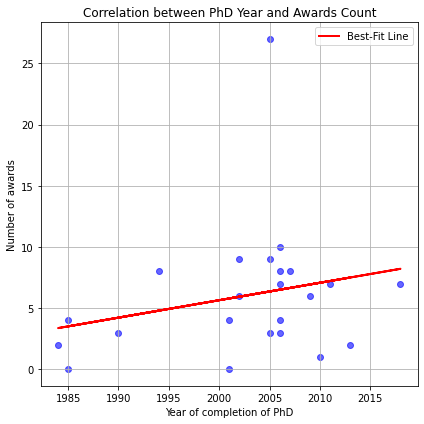

In [194]:
# Scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(df['Year'], df['Awards'], color='blue', alpha=0.6)
plt.title('Correlation between PhD Year and Awards Count')
plt.xlabel('Year of completion of PhD')
plt.ylabel('Number of awards')
plt.grid(True)

# Plot the best-fit line
plt.plot(df['Year'], line, color='red', linewidth=2, label='Best-Fit Line')

plt.legend()
plt.tight_layout()
plt.show()

Statistical analysis of PhD location vs year of completion

In [195]:

# Separate the numerical variable 'years' based on the categories in 'location'
years_india = df[df['Location'] == 'India']['Year']
years_other = df[df['Location'] == 'Abroad']['Year']

# Perform independent two-sample t-test
t_stat, p_value = ttest_ind(years_india, years_other)

# Print the t-statistic and p-value
print("T-statistic:", t_stat)
print("P-value:", p_value)


T-statistic: -0.5313919391433574
P-value: 0.600723525471373


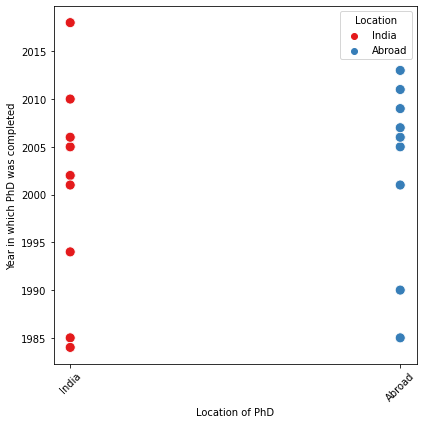

In [197]:
plt.figure(figsize=(6, 6))
sb.scatterplot(x='Location', y='Year', data=df, hue='Location', palette='Set1', s=100)
plt.xlabel('Location of PhD')
plt.ylabel('Year in which PhD was completed')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

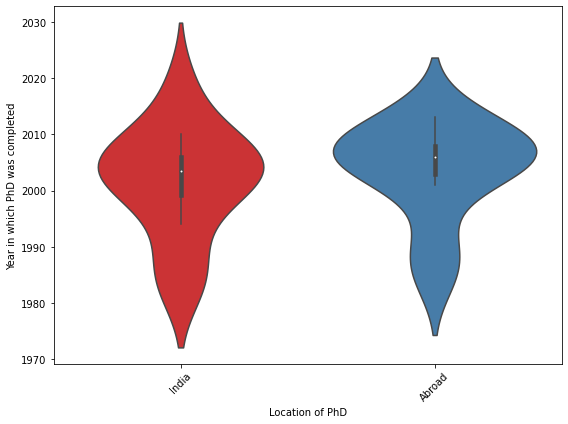

In [297]:
# Create a box plot to visualize the relationship between 'Location' and 'Year'
plt.figure(figsize=(8, 6))
sb.violinplot(x='Location', y='Year', data=df, palette='Set1')
plt.xlabel('Location of PhD')
plt.ylabel('Year in which PhD was completed')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Extracting year of appointment as Assistant Professor

In [241]:
assistant_professor_sentences = []

# Split data based on "}"
for row in rows:
    segments = row[4].split("}")  
    found_prof = False
    
    for segment in segments:
        if re.search(r'.*?Assistant Professor.*?', segment, re.IGNORECASE):
            assistant_professor_sentences.append(segment.strip())
            found_prof = True
            break 
    
    if not found_prof:
        assistant_professor_sentences.append(None)  # Append None if no PhD sentence is found in the row

In [242]:
year_pattern = r'\b\d{4}\b'

# Extract starting years when someone became an Assistant Professor
assistant_professor_starting_years = []
for item in assistant_professor_sentences:
    if item is not None:
        # Extract the first occurrence of a four-digit number from the item using the regular expression pattern
        match = re.search(year_pattern, item)
        if match:
            # Add the extracted starting year to the result list
            assistant_professor_starting_years.append(match.group())
        else:
            # If no year is present, append None to the result list
            assistant_professor_starting_years.append(None)
    else:
        # If the item is None, append None to the result list
        assistant_professor_starting_years.append(None)

In [299]:
df_prof_year = pd.DataFrame({'name':assistant_professor_sentences, "year":assistant_professor_starting_years, 'phd':phd_years})
df_prof_year

,name,year,phd
0,None,None,2010.0
1,"Assistant Professor, IIT Bombay, India (2009 o...",2009,2006.0
2,"Assistant Professor, Department of Biosciences...",2022,2011.0
3,None,None,2006.0
4,Assistant Professor (May 2012 – May 2017): Dep...,2012,2005.0
5,Assistant Professor : School of Biosciences & ...,None,NaN
6,"2022 – present: Assistant Professor, Departmen...",2022,2018.0
7,Assistant Professor (2011 – 2019): Department ...,2011,2009.0
8,None,None,2013.0
9,Assistant Professor & DBT-Wellcome Trust Inter...,2021,2006.0


In [269]:
df_prof_year = df_prof_year.dropna(subset=['year'])
df_prof_year = df_prof_year.dropna(subset=['phd'])
df_prof_year.reset_index(drop=True, inplace=True)
df_prof_year

,name,year,phd
0,"Assistant Professor, IIT Bombay, India (2009 o...",2009,2006.0
1,"Assistant Professor, Department of Biosciences...",2022,2011.0
2,Assistant Professor (May 2012 – May 2017): Dep...,2012,2005.0
3,"2022 – present: Assistant Professor, Departmen...",2022,2018.0
4,Assistant Professor (2011 – 2019): Department ...,2011,2009.0
5,Assistant Professor & DBT-Wellcome Trust Inter...,2021,2006.0
6,2012 – 2020: Reader (Assistant Professor) in t...,2012,2001.0
7,Assistant Professor : Indian Institute of Tech...,2009,2005.0
8,"April 2003 – March 2007 Assistant Professor, S...",2003,1990.0
9,"Feb 2009 – Sept 2014: Assistant Professor, IIT...",2009,2002.0


Finding the frequency of hires in a yearwise manner and plotting the data

In [293]:
# Convert starting years to integers
starting_years = [int(year) for year in df_prof_year['year'] if year is not None]

# Count the frequency of each starting year
year_counts = Counter(starting_years)

# Extract years and corresponding counts
years = list(year_counts.keys())
counts = list(year_counts.values())


c:\Users\sapna\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


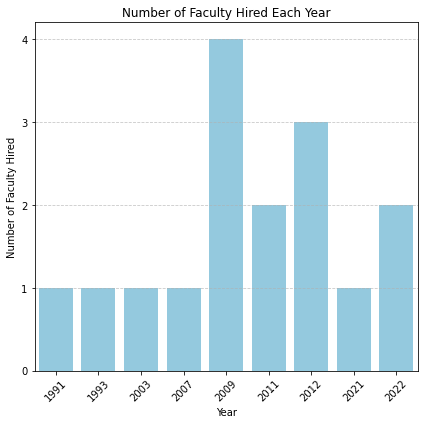

In [294]:
# Plotting the bar chart
plt.figure(figsize=(6, 6))
sb.barplot(years,counts, color='skyblue')
plt.xlabel('Year')
plt.ylabel('Number of Faculty Hired')
plt.title('Number of Faculty Hired Each Year')
plt.xticks(rotation=45)
plt.yticks(np.arange(0,5,1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

c:\Users\sapna\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


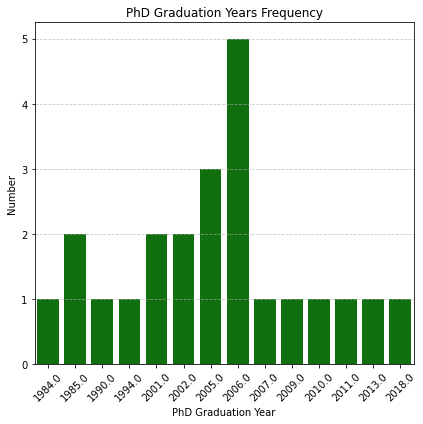

In [298]:
# Count the frequency of each Ph.D. graduation year
year_counts = {}
for year in df_prof_year['phd']:
    year_counts[year] = year_counts.get(year, 0) + 1

# Extract years and corresponding frequencies
years = list(year_counts.keys())
frequencies = list(year_counts.values())

# Create a bar plot
plt.figure(figsize=(6, 6))
sb.barplot(years, frequencies, color = 'green')
plt.xlabel('PhD Graduation Year')
plt.ylabel('Number')
plt.title('PhD Graduation Years Frequency')
plt.xticks(rotation=45) 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()  # Ensures labels are not cut off
plt.show()


Statistical analysis of year of completion of PhD and year of appointment as Assistant Professor

In [282]:
df_prof_year['phd'] = pd.to_numeric(df_prof_year['phd'], errors='coerce')
df_prof_year['year'] = pd.to_numeric(df_prof_year['year'], errors='coerce')

In [285]:
# Calculate best-fit line (linear regression)
slope, intercept, r_value, p_value, std_err = linregress(df_prof_year['phd'], df_prof_year['year'])
line = slope * df_prof_year['phd'] + intercept

# Calculate predicted values
predeicted_years = slope * df_prof_year['phd'] + intercept

# Calculate mean squared error
mse = ((df_prof_year['year'] - predicted_years) ** 2).mean()

# Print R-squared value, p-value, and mean squared error
print('r-squared:', r_value ** 2)
print('r-value:', r_value)
print('p-value:', p_value)
print('Mean Squared Error:', mse)


r-squared: 0.7958945794805347
r-value: 0.8921292392252003
p-value: 3.4115238468274845e-06
Mean Squared Error: 14.43966121495359


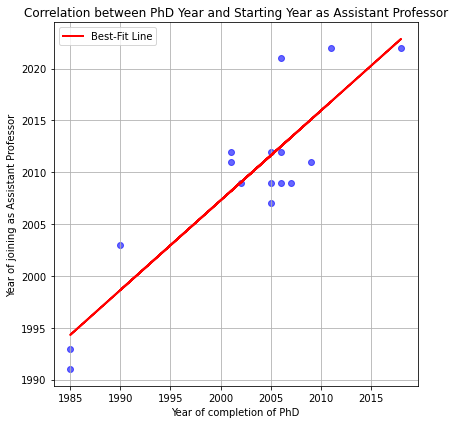

In [288]:
plt.figure(figsize=(6, 6))
plt.scatter(df_prof_year['phd'], df_prof_year['year'], color='blue', alpha=0.6)
plt.title('Correlation between PhD Year and Starting Year as Assistant Professor')
plt.xlabel('Year of completion of PhD')
plt.ylabel('Year of joining as Assistant Professor')
plt.grid(True)

# Plot the best-fit line
plt.plot(df_prof_year['phd'], line, color='red', linewidth=2, label='Best-Fit Line')

plt.legend()
plt.tight_layout()
plt.show()